In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]


# Multi-quantile estimations

In [2]:
# Dataset generation
distros = ['mix', 'gau_1', 'gau_2', 'exp']

def get_one_dt(distro, datasize):
#     return np.ones(size)
    if distro == 'gau_1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau_2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        # mean: -1.3
        # std: 30.779035604224564
        # var: 947.3490327261234
        mix_lst = np.zeros(datasize)
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25])
        mixtures = [(2,7), (0,0.7), (36, 26), (5,77), (-77,7)]
        acc_sizes = [sum(sizes[:i+1]) for i in range(len(sizes))]

        for d_idx in range(datasize):
            rdn = np.random.uniform(0,1)
            mix_id = 0
            for m_id in acc_sizes:
                if rdn > m_id:
                    mix_id += 1
                else:break
            data_point = np.random.normal(mixtures[mix_id][0], mixtures[mix_id][1])
            mix_lst[d_idx] = data_point
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)*6.5 - 20
    else: raise Exception("distribution doesn't work!")

In [3]:
# dt = get_one_dt('exp', 10000)
# plt.hist(dt, bins=100)

## Joint Tracking of Multiple Quantiles Through Condition Quantiles

1. Algo based on DUMIQUE (basically SGD but claim itself not ablt to deal with non-positive quantiles directly)

In [39]:
# not sure why *q_est --> Cannot deal with q_est<0
def DUMIQUE(q_est, x, tau, stepsize):
    if q_est < 0: raise Exception("!!!", q_est)
    if x > q_est:
        q_est += (stepsize*q_est)*tau
    else:
        q_est += (stepsize*q_est)*(tau-1)
    return q_est

# SGD which works for q_est non positive, only constant stepsize
def sgd(q_est, x, tau, stepsize):
    if x > q_est:
        q_est += stepsize*tau
    else:
        q_est += stepsize*(tau-1)
    return q_est

In [42]:
def checkinput(q_est):
    q_new = [0]
    q_new.extend([q_est[i] for i in range(len(q_est)-1)])
    for i in range(len(q_est)):
        if q_new[i] >= q_est[i]: return False
    return True

# sX is stepsize_X, sY is stepsize_Y
# c = 2 because 0.5 is at tau_vals[2]
def shiftQ(dataset, tau_lst, sX, sY, qX, qY, c=0):
    if not (checkinput(qX) and checkinput(qY)):
        raise Exception("Input quantile estimate not applicable")
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        qX[c] = DUMIQUE(qX[c], x, tau_lst[c], sX)

        for k in range(c-1, -1, -1):
            tau = tau_lst[k]
#           shifted observation
            yk = qX[k+1] - x
#           shifted Y distro
            qY[k] = DUMIQUE(qY[k], yk, tau, sY)
#           shift back
            qX[k] = qX[k+1] - qY[k]
#             print ('yk', yk)
#             print ('qY', qY)
#             print ('qX', qX)
        
        for k in range(c+1, len(qX)):
            tau = tau_lst[k]
            yk = -qX[k-1] + x
            qY[k] = DUMIQUE(qY[k], yk, tau, sY)
            qX[k] = qX[k-1] + qY[k]
#             print ('yk',yk)
#             print ('qY', qY)
#             print ('qX', qX)
#         print ('qY', qY)
        proc[i] = qX
    return proc


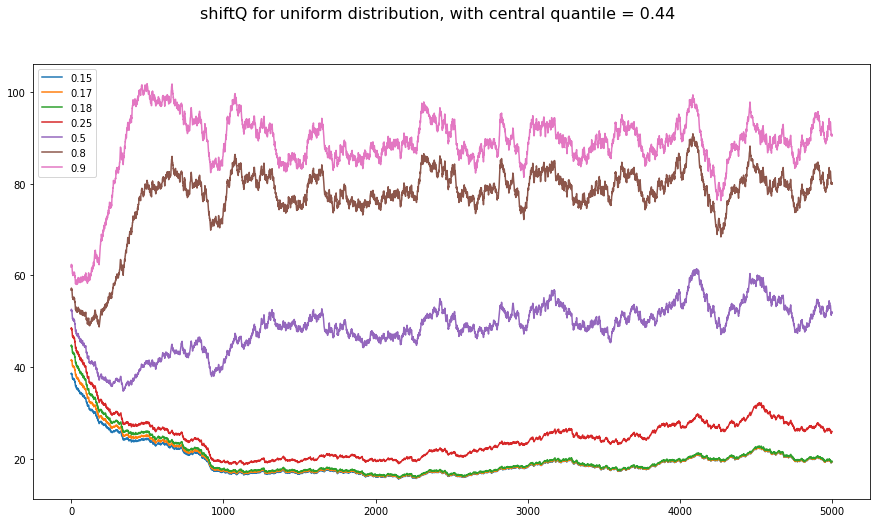

[[19.1939182  19.22706442 19.36432202 25.78742829 51.74471936 80.00603867
  90.57318344]
 [19.22820786 19.26145352 19.3991778  25.8543996  52.07126358 80.21953762
  90.7655481 ]
 [19.26255838 19.29590378 19.43409632 25.92159423 51.87628957 79.91197051
  90.43688897]]


In [43]:
dataset = np.random.uniform(0, 100, 5000)
qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
qY = np.asarray([30.0, 32, 36, 38, 40.0, 45, 50])/10.0
tau_lst = [0.15, 0.17, 0.18, 0.25, 0.5, 0.8, 0.9]
proc = shiftQ(dataset, tau_lst, 0.01, 0.02, qX, qY, 2)
# print (proc)
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
ax.plot(proc)
ax.legend(tau_lst)
fig.suptitle("shiftQ for uniform distribution, with central quantile = 0.44", fontsize = 16)
plt.show()

print (proc[-3:, :])


#### Explanation

1. **Overall:** The basic idea is to estimate a central quantile point, and update other quantiles based on the central one. 

2. **Motivation:** The difference $diff$ between the two quantiles for the $x_{n}$ observation is:
$$
diff = |Q_x(q_{k+1}) - Q_x(q_k)|
$$
    Note that $diff > 0$ for all time, so different quantiles never cross each other. This property is guaranteed by the update function DUMIQE() and its restriction that the input quantile estimate must > 0.

2. **Update one quantile:** The difference is calculated based on the idea of "shift distribution". Let $X$ denotes the original distribution of data stream, and let distribution $Y$ denotes a shifted version of $X$ such that $Y = X + constant$. In this way, the quantile $q_{k+1}$ can be updated by implementation of shifting. The basic steps are:
    1. Calculate $Q_x(q_k)$, which is the shift constant
    2. Get shift observation $y_{k+1} =  Q_x(q_k) - x$
    3. Calculate the new quantile $Q_y(q_{k+1})$ in $Y$
    4. Shift the change back to $X$: $Q_x(q_{k+1}) = Q_y(q_{k+1}) + shiftConstant$

3. **Update the bigger quantiles:** Starting from central quantile $q_c$, the estimates for $q_{c+1}, ..., q_{K}$ are calculated one based on another. So each time step 2 is repeated from $q_c$ to $q_{K-1}$

4. **Update the smaller quantiles:** Similar to step 3, for smaller quantiles, estimates for $q_{c-1}, ..., q_{1}$ are calculated similarly one based on another.

#### Observation and Analysis

1. The quantiles greater than the central quantile work well. We can see the biggest 3 quantiles are converging close to the true quantiles.

2. The quantiles smaller than central quantile converges to the central quantile. Specially, the smallest quantile first converge to the second one, then the second one to the third one, until all of the small ones converge to the central one.
    
    **Explanation:**
    
    Let's assume $Q_x(q_{c-1})$ is already on it's track converging to $Q_x(q_c)$.
    On the arrival of new observation $x$, the update of $Q_x(q_{c-1})$ is 
    $$ Q_x(q_{c-1}) = Q_x(q_{c}) - Q_y(q_{c-1})$$
    We can observe from the data the difference $Q_y(q_{c-1})$ is decreasing. But I don't know why
    
    
    
    

### Comparison with SGD

In [31]:
def SGD(dataset, tau_lst, stepsize, q):
    if not (checkinput(q)):
        raise Exception("Input quantile estimate not applicable")
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        for k in range(len(tau_lst)):
            tau = tau_lst[k]
            q[k] = sgd(q[k], x, tau, stepsize)
#         if not (checkinput(q)):
#             print ("!!! Cross !!!", q)
        proc[i] = q
    return proc

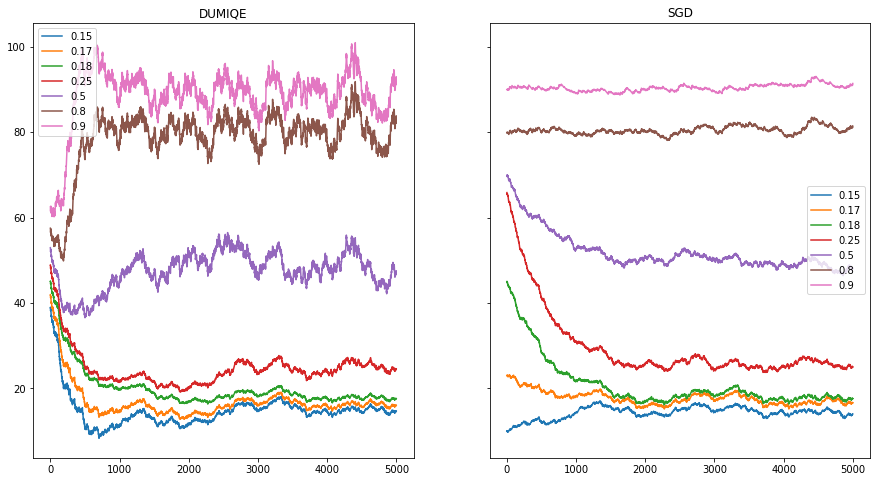

ShiftQ res [14.6425289  16.01532978 17.57903848 24.46979214 47.48944979 83.79373686
 92.95379189]
SGD res    [14.  16.6 17.6 25.  48.2 81.4 91.4]
True res   [15. 17. 18. 25. 50. 80. 90.]


In [33]:
qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
# print (qX)
proc2 = SGD(dataset, tau_lst, 0.2, qX)
# print (proc)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8), sharey=True)
ax1.plot(proc)
ax1.set_title("DUMIQE")
ax2.plot(proc2)
ax2.set_title("SGD")

ax1.legend(tau_lst)
ax2.legend(tau_lst)
plt.show()

print ("ShiftQ res", proc[-1, :])
print ("SGD res   ", proc2[-1, :])
print ("True res  ", np.asarray(tau_lst)*100)

Obviously SGD is better: it at least conveges to the correct value. But **crossing problem not solved**

## Joint Tracking of Multiple Quantiles Through Condition Quantiles

Algo based on QEWA -- Too complicated, not going to implement this now


### Tracking Quantiles of Network Data Streams with Dynamic Options

Jin Cao, ...

Not going to implement this

## P2

Exponentially Weighted Simultaneous Esimation of Several Quantiles